In [1]:
from model_settings import ms
import requests
import numpy as np
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import QuantLib as ql


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual



In [2]:
key = ms.av_key
symbol = 'SPY'
date = '2024-05-17'

In [3]:
underlying_url = str(
    "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY"
    f"&symbol={symbol}&date={date}&outputsize=compact&apikey={key}"
    )
spotr = requests.get(underlying_url)
spots = pd.DataFrame(spotr.json()['Time Series (Daily)']).T
spots = spots.astype(float)

spots['mid'] = np.array(
    (spots['3. low'].values + spots['2. high'].values)/2
    )
spots.index = pd.to_datetime(spots.index,format='%Y-%m-%d')
spot = float(spots['4. close'][date])

options_url = str(
    "https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&"
    f"symbol={symbol}"
    f"&date={date}"
    f"&apikey={key}"
          )

r = requests.get(options_url)
data = r.json()

In [4]:
spot

529.45

In [5]:
df = pd.DataFrame(data['data'])
columns_to_convert = ['strike', 'last', 'mark',
       'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho']
df[columns_to_convert] = df[
    columns_to_convert].apply(pd.to_numeric, errors='coerce')

df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]

df = df[df['volume']>0].copy()

df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

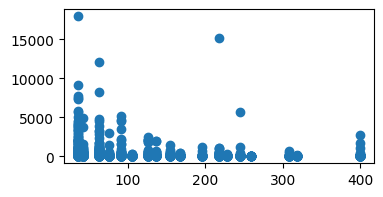

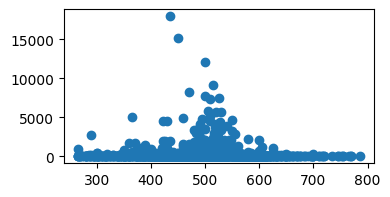

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(4,2))
plt.scatter(df['days_to_maturity'],df['volume'])
plt.show()
plt.figure(figsize=(4,2))
plt.scatter(df['strike'],df['volume'])
plt.show()
plt.clf()

In [7]:
s = spot
T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass

In [8]:
volume_heatmap

,35,42,63,75,91,105,126,136,154,167,196,217,228,245,259,308,318,399
265.0,988.0,NaN,NaN,NaN,5.0,NaN,55.0,NaN,51.0,NaN,NaN,58.0,NaN,NaN,NaN,NaN,NaN,NaN
270.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN
275.0,NaN,NaN,NaN,NaN,10.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280.0,33.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,7.0
285.0,NaN,NaN,NaN,NaN,120.0,NaN,5.0,NaN,NaN,NaN,NaN,7.0,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
755.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,53.0,NaN,NaN
765.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,1.0


In [9]:
hottest = 50

In [75]:
hottest_contracts = pd.DataFrame(volume_heatmap.unstack().sort_values(ascending=False)).head(hottest).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
KK,TT = np.meshgrid(K,T)
VV = np.array(
        [[vol_matrix.loc[k,t] for k in K] for t in T]
        )

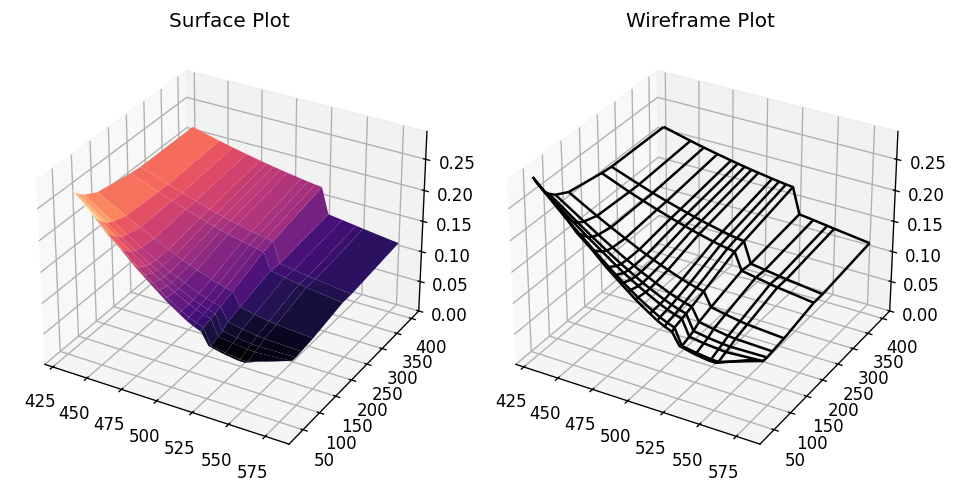

In [94]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(KK, TT, VV, rstride=1, cstride=1, cmap=cm.magma, linewidth=0.1)
ax1.set_zlim(0, float(max(vol_matrix.values.flatten())))
ax1.set_title('Surface Plot')

# Second subplot for wireframe plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_wireframe(KK, TT, VV, rstride=1, cstride=1,color='black')
ax2.set_zlim(0, float(max(vol_matrix.values.flatten())))
ax2.set_title('Wireframe Plot')

plt.tight_layout()
plt.show()